# 머신러닝 통합 실습
## 주성분분석(PCA)과 군집분석(Clustering)

이 노트북에서는 다음 내용을 다룹니다:
1. **데이터 시각화와 상관관계 분석**
2. **주성분분석(PCA)을 통한 차원축소**
3. **K-Means 클러스터링 기본 예제**
4. **실제 데이터를 이용한 클러스터링**


## 1. 데이터 시각화와 상관관계 분석

특성이 많은 고차원 데이터에서는 다음과 같은 방법으로 데이터를 분석할 수 있습니다:
- **산포도 행렬(Pairplot)**: 특성 간의 관계를 시각화
- **히스토그램**: 클래스별 데이터 분포 확인  
- **히트맵**: 상관관계 행렬 시각화

### 필요한 라이브러리 import


In [9]:
# 모든 필요한 라이브러리 import
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd 
import numpy as np

# scikit-learn 라이브러리
from sklearn.datasets import load_iris, load_breast_cancer, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score

# 경고 메시지 숨기기 (선택사항)
import warnings
warnings.filterwarnings('ignore')

print("모든 라이브러리가 성공적으로 import되었습니다!")


모든 라이브러리가 성공적으로 import되었습니다!


### 유방암 데이터셋 로드 및 DataFrame 변환


In [10]:
# 유방암 데이터셋 로드
cancer = load_breast_cancer()

# Bunch 객체를 DataFrame으로 변환
df1 = pd.DataFrame(cancer['data'], columns=cancer['feature_names'])
df1['target'] = cancer['target']

print("데이터셋 정보:")
print(f"데이터 형태: {df1.shape}")
print(f"특성 개수: {len(cancer['feature_names'])}")
print("\n첫 5행 데이터:")
print(df1.head())

데이터셋 정보:
데이터 형태: (569, 31)
특성 개수: 30

첫 5행 데이터:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst textur

### 클래스별 특성 분포 히스토그램

악성(malignant)과 양성(benign) 종양 데이터의 특성별 분포를 히스토그램으로 시각화합니다.


악성 종양 데이터: (212, 30)
양성 종양 데이터: (357, 30)


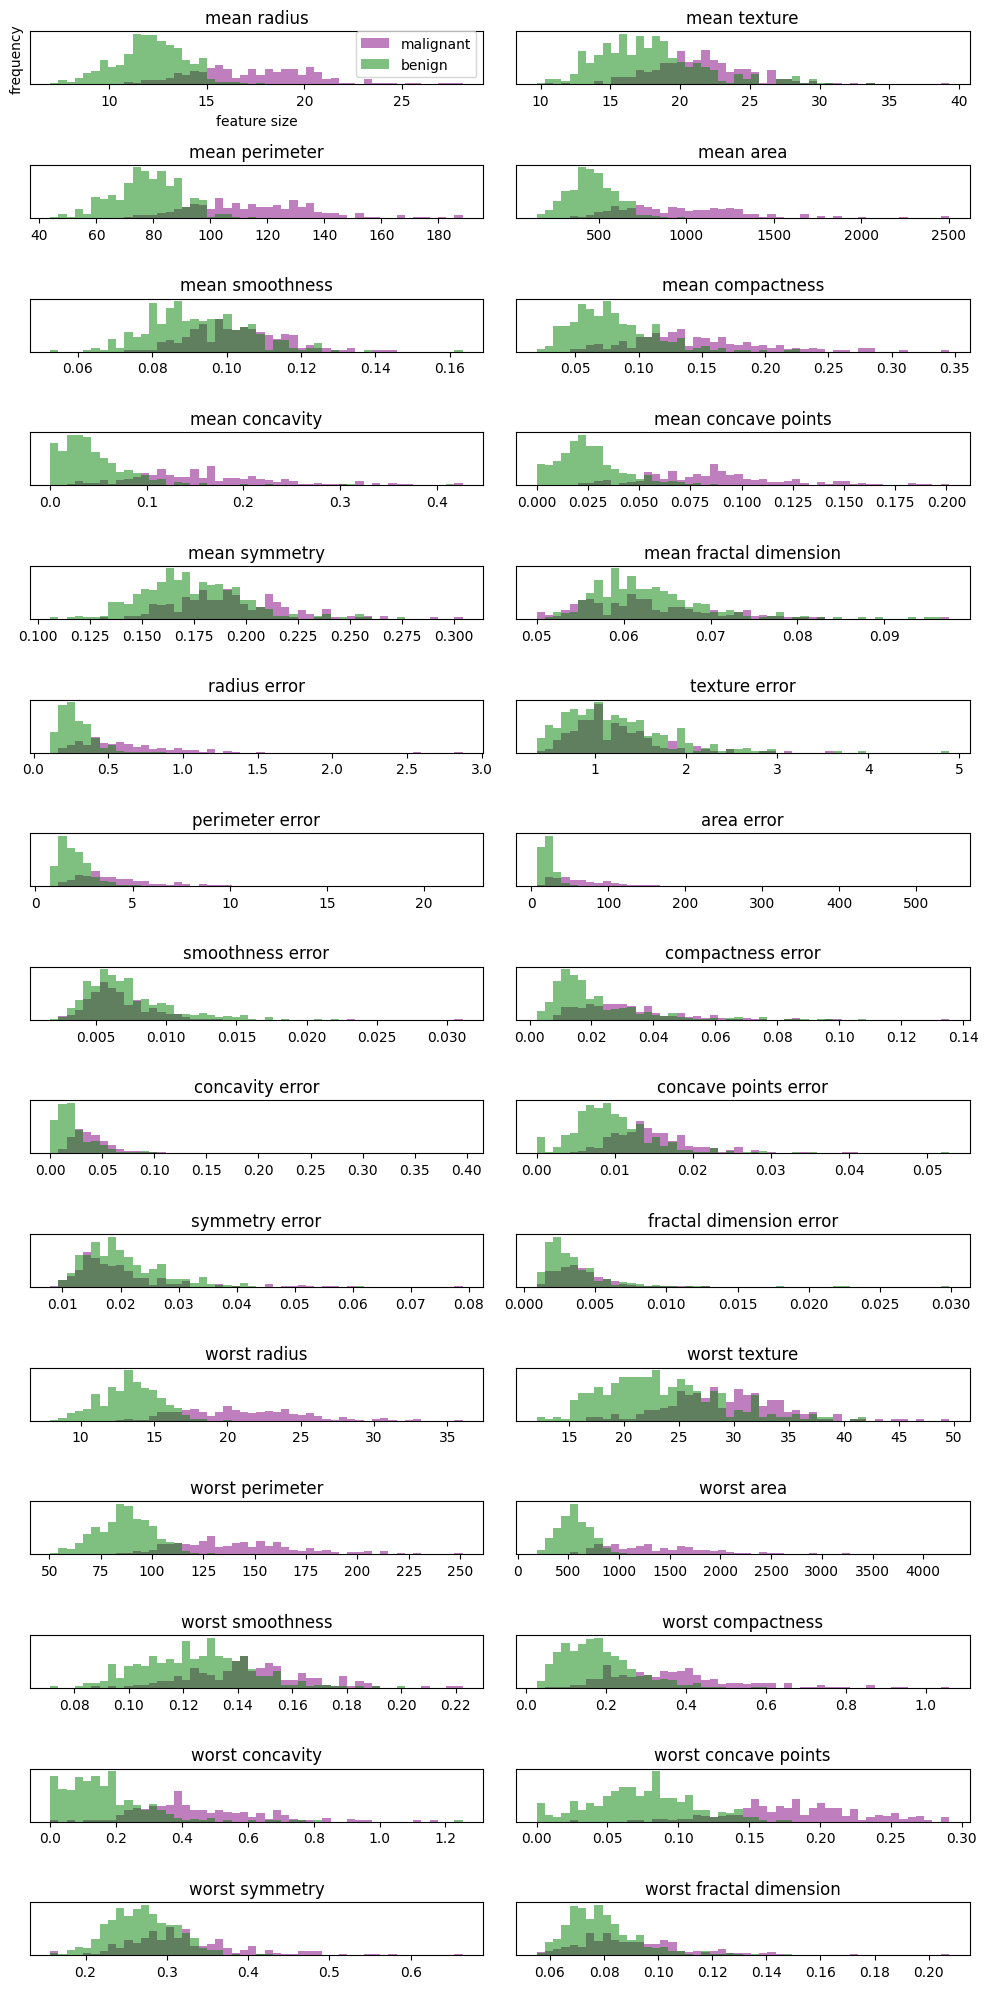

In [11]:
# 데이터를 악성과 양성으로 분리
cancer_data = cancer['data']
cancer_target = cancer['target']

# 악성(0)과 양성(1) 데이터 분리
malignant = cancer_data[cancer_target==0]  # 악성종양 데이터
benign = cancer_data[cancer_target==1]     # 양성종양 데이터

print(f"악성 종양 데이터: {malignant.shape}")
print(f"양성 종양 데이터: {benign.shape}")

# 30개 특성의 히스토그램을 15x2 그리드로 그리기
fig, axes = plt.subplots(15, 2, figsize=(10, 20))
ax = axes.ravel()  # 축 정보를 1차원으로 변환

for i in range(30):  # 30개 특성
    # 히스토그램 구간 설정
    count, bins = np.histogram(cancer_data[:, i], bins=50)
    
    # 악성과 양성 데이터의 히스토그램
    ax[i].hist(malignant[:, i], bins=bins, color='purple', alpha=0.5, label='malignant')
    ax[i].hist(benign[:, i], bins=bins, color='green', alpha=0.5, label='benign')
    
    # 제목 설정
    ax[i].set_title(cancer['feature_names'][i])
    ax[i].set_yticks(())  # y축 눈금 제거

# 범례 및 라벨 설정
ax[0].set_xlabel('feature size')
ax[0].set_ylabel('frequency')
ax[0].legend(['malignant', 'benign'], loc='best')

fig.tight_layout()  # 차트 재정렬
plt.show()

### 상관관계 히트맵

특성 간의 상관관계를 히트맵으로 시각화합니다. 특성이 많을 때 산포도 행렬 대신 자주 사용되는 방법입니다.


상관관계 행렬 (처음 10개 특성):
                        mean radius  mean texture  mean perimeter  mean area  \
mean radius                1.000000      0.323782        0.997855   0.987357   
mean texture               0.323782      1.000000        0.329533   0.321086   
mean perimeter             0.997855      0.329533        1.000000   0.986507   
mean area                  0.987357      0.321086        0.986507   1.000000   
mean smoothness            0.170581     -0.023389        0.207278   0.177028   
mean compactness           0.506124      0.236702        0.556936   0.498502   
mean concavity             0.676764      0.302418        0.716136   0.685983   
mean concave points        0.822529      0.293464        0.850977   0.823269   
mean symmetry              0.147741      0.071401        0.183027   0.151293   
mean fractal dimension    -0.311631     -0.076437       -0.261477  -0.283110   

                        mean smoothness  mean compactness  mean concavity  \
mean radius          

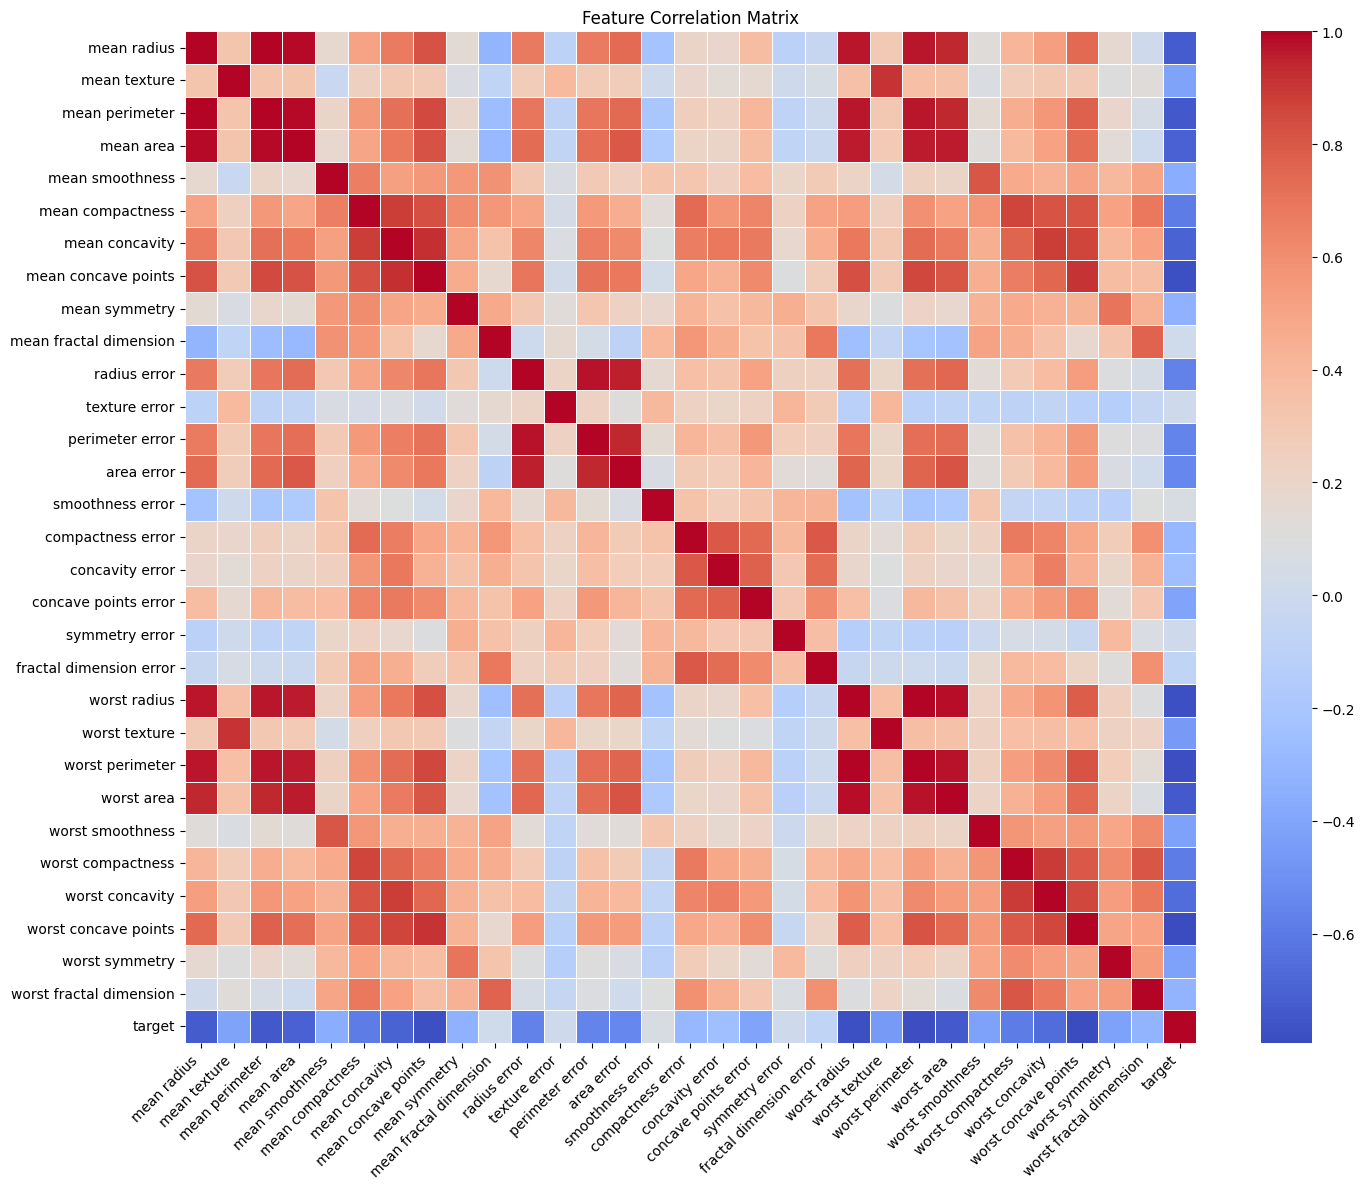

In [12]:
# 상관관계 행렬 계산
correlation_matrix = df1.corr()
print("상관관계 행렬 (처음 10개 특성):")
print(correlation_matrix.iloc[:10, :10])

# 히트맵 그리기
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, 
            annot=False,      # 값 표시 안함 (너무 많아서)
            cmap='coolwarm',  # 빨간색(양의 상관관계), 파란색(음의 상관관계)
            fmt='.2f',        # 소수점 둘째 자리까지
            linewidths=0.5,   # 셀 사이 선 추가
            square=True)      # 정사각형 모양

plt.title('Feature Correlation Matrix')
plt.xticks(rotation=45, ha='right')  # x축 레이블 회전
plt.yticks(rotation=0)
plt.tight_layout()  # 레이블 겹침 방지
plt.show()

## 2. 주성분분석(PCA) - 차원축소

PCA는 고차원 데이터의 차원을 축소하는 기법입니다:
- **다중공선성 제거**: 상관관계가 높은 특성들로부터 새로운 특성 생성
- **노이즈 제거**: 분산이 낮은 성분 제거로 노이즈 감소
- **과적합 방지**: 특성 수 감소로 모델 일반화 성능 향상
- **시각화**: 2-3차원으로 축소하여 데이터 시각화 가능
- **계산 속도 향상**: 특성 수 감소로 학습 시간 단축


In [13]:
# digits 데이터셋 로드 (손글씨 숫자 인식)
digits = load_digits()
X = digits.data
y = digits.target

print(f"원본 데이터 형태: {X.shape}")
print(f"클래스 수: {len(np.unique(y))}")
print(f"각 이미지 크기: 8x8 = 64 픽셀")

원본 데이터 형태: (1797, 64)
클래스 수: 10
각 이미지 크기: 8x8 = 64 픽셀


### 데이터 전처리 및 PCA 적용


In [14]:
# 스케일링 (PCA는 특성들의 스케일에 민감하므로 필수)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

# 주성분분석 (64차원 → 10차원으로 축소)
pca = PCA(n_components=10)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

print(f"스케일링 후 데이터 형태: {X_scaled.shape}")
print(f"PCA 후 데이터 형태: {X_pca.shape}")
print(f"차원 축소: {X.shape[1]} → {X_pca.shape[1]}")

# 각 주성분이 설명하는 분산 비율
print(f"\n각 주성분의 설명 분산 비율:")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {ratio:.3f}")
    
print(f"\n총 설명 분산 비율: {pca.explained_variance_ratio_.sum():.3f}")

스케일링 후 데이터 형태: (1797, 64)
PCA 후 데이터 형태: (1797, 10)
차원 축소: 64 → 10

각 주성분의 설명 분산 비율:
PC1: 0.120
PC2: 0.096
PC3: 0.084
PC4: 0.065
PC5: 0.049
PC6: 0.042
PC7: 0.039
PC8: 0.034
PC9: 0.030
PC10: 0.029

총 설명 분산 비율: 0.589


### PCA 전후 성능 비교


In [15]:
# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train_scaled, X_test_scaled, _, _ = train_test_split(X_scaled, y, random_state=42, test_size=0.2)
X_train_pca, X_test_pca, _, _ = train_test_split(X_pca, y, random_state=42, test_size=0.2)

# 로지스틱 회귀 모델
model = LogisticRegression(max_iter=1000, random_state=42)

# 1. 원본 데이터
model.fit(X_train, y_train)
train_score_original = model.score(X_train, y_train)
test_score_original = model.score(X_test, y_test)

# 2. 스케일링된 데이터
model.fit(X_train_scaled, y_train)
train_score_scaled = model.score(X_train_scaled, y_train)
test_score_scaled = model.score(X_test_scaled, y_test)

# 3. PCA 적용된 데이터
model.fit(X_train_pca, y_train)
train_score_pca = model.score(X_train_pca, y_train)
test_score_pca = model.score(X_test_pca, y_test)

# 결과 출력
print("="*50)
print("성능 비교 결과")
print("="*50)
print(f"{'방법':<15} {'훈련 정확도':<12} {'테스트 정확도':<12}")
print("-"*50)
print(f"{'원본 데이터':<15} {train_score_original:<12.3f} {test_score_original:<12.3f}")
print(f"{'스케일링':<15} {train_score_scaled:<12.3f} {test_score_scaled:<12.3f}")
print(f"{'PCA (10차원)':<15} {train_score_pca:<12.3f} {test_score_pca:<12.3f}")
print("="*50)

성능 비교 결과
방법              훈련 정확도       테스트 정확도     
--------------------------------------------------
원본 데이터          1.000        0.975       
스케일링            0.999        0.972       
PCA (10차원)      0.898        0.897       


## 3. 군집분석(Clustering) - K-Means

군집분석은 비지도학습의 한 종류로, 레이블 없이 데이터를 유사한 그룹으로 분류합니다:
- **K-Means**: 데이터를 k개의 군집으로 분할
- **중심점 기반**: 각 군집의 중심점(centroid)을 기준으로 분류
- **거리 기반**: 유클리드 거리를 사용하여 가장 가까운 중심점에 할당

### 인공 데이터를 이용한 기본 예제


In [16]:
# 시드 설정 (재현 가능한 결과를 위해)
np.random.seed(42)

# 3개 그룹의 인공 데이터 생성
# 각 그룹은 서로 다른 중심점과 분산을 가짐
x1 = np.random.normal(0, 1, (50, 2))    # 중심점 (0, 0)
x2 = np.random.normal(5, 1, (50, 2))    # 중심점 (5, 5)  
x3 = np.random.normal(2.5, 1, (50, 2))  # 중심점 (2.5, 2.5)

# 데이터를 세로로 결합
X_synthetic = np.vstack((x1, x2, x3))

print(f"인공 데이터 형태: {X_synthetic.shape}")
print(f"총 데이터 포인트: {X_synthetic.shape[0]}개")
print("처음 10개 데이터:")
print(X_synthetic[:10])


인공 데이터 형태: (150, 2)
총 데이터 포인트: 150개
처음 10개 데이터:
[[ 0.49671415 -0.1382643 ]
 [ 0.64768854  1.52302986]
 [-0.23415337 -0.23413696]
 [ 1.57921282  0.76743473]
 [-0.46947439  0.54256004]
 [-0.46341769 -0.46572975]
 [ 0.24196227 -1.91328024]
 [-1.72491783 -0.56228753]
 [-1.01283112  0.31424733]
 [-0.90802408 -1.4123037 ]]


군집 레이블 (처음 20개):
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

군집 중심점:
군집 0: (4.90, 5.19)
군집 1: (-0.15, -0.04)
군집 2: (2.70, 2.47)


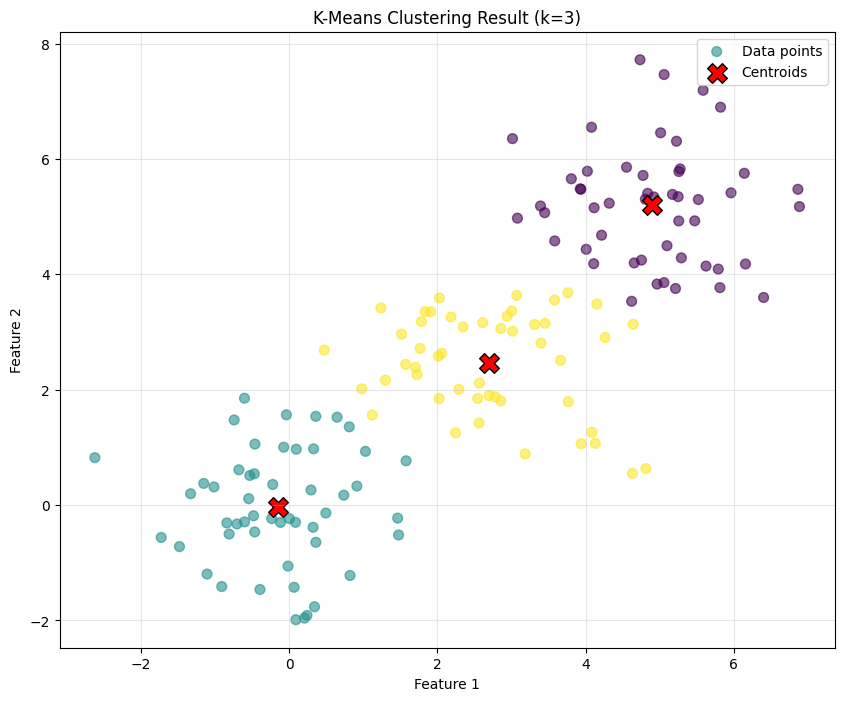

In [17]:
# K-Means 클러스터링 적용 (k=3)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_synthetic)

# 각 데이터 포인트의 군집 레이블 예측
y_kmeans = kmeans.predict(X_synthetic)

# 군집 중심점 가져오기
centers = kmeans.cluster_centers_

print("군집 레이블 (처음 20개):")
print(y_kmeans[:20])
print(f"\n군집 중심점:")
for i, center in enumerate(centers):
    print(f"군집 {i}: ({center[0]:.2f}, {center[1]:.2f})")

# 결과 시각화
plt.figure(figsize=(10, 8))

# 데이터 포인트를 군집별로 색상을 다르게 표시
plt.scatter(X_synthetic[:, 0], X_synthetic[:, 1], 
           c=y_kmeans, cmap='viridis', s=50, alpha=0.6, label='Data points')

# 군집 중심점 표시
plt.scatter(centers[:, 0], centers[:, 1], 
           c='red', s=200, marker='X', label='Centroids', edgecolors='black')

plt.title('K-Means Clustering Result (k=3)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 4. 실제 데이터를 이용한 클러스터링

Iris 데이터셋을 사용하여 실제 데이터에 대한 클러스터링을 수행해봅시다.

### 군집 개수 선택의 중요성
- **원래보다 적게**: 유사한 군집끼리 합쳐짐 → 정보 손실
- **원래보다 많게**: 강제로 군집을 더 세분화 → 과분할
- **적절한 개수**: 엘보우 방법, 실루엣 분석, 전문가 지식 활용

In [18]:
# Iris 데이터셋 로드
iris = load_iris()
X_iris = iris.data
y_true = iris.target  # 실제 레이블 (비교용)

print(f"Iris 데이터 형태: {X_iris.shape}")
print(f"특성 이름: {iris.feature_names}")
print(f"클래스 이름: {iris.target_names}")
print("처음 10개 데이터:")
print(X_iris[:10])

Iris 데이터 형태: (150, 4)
특성 이름: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
클래스 이름: ['setosa' 'versicolor' 'virginica']
처음 10개 데이터:
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]]


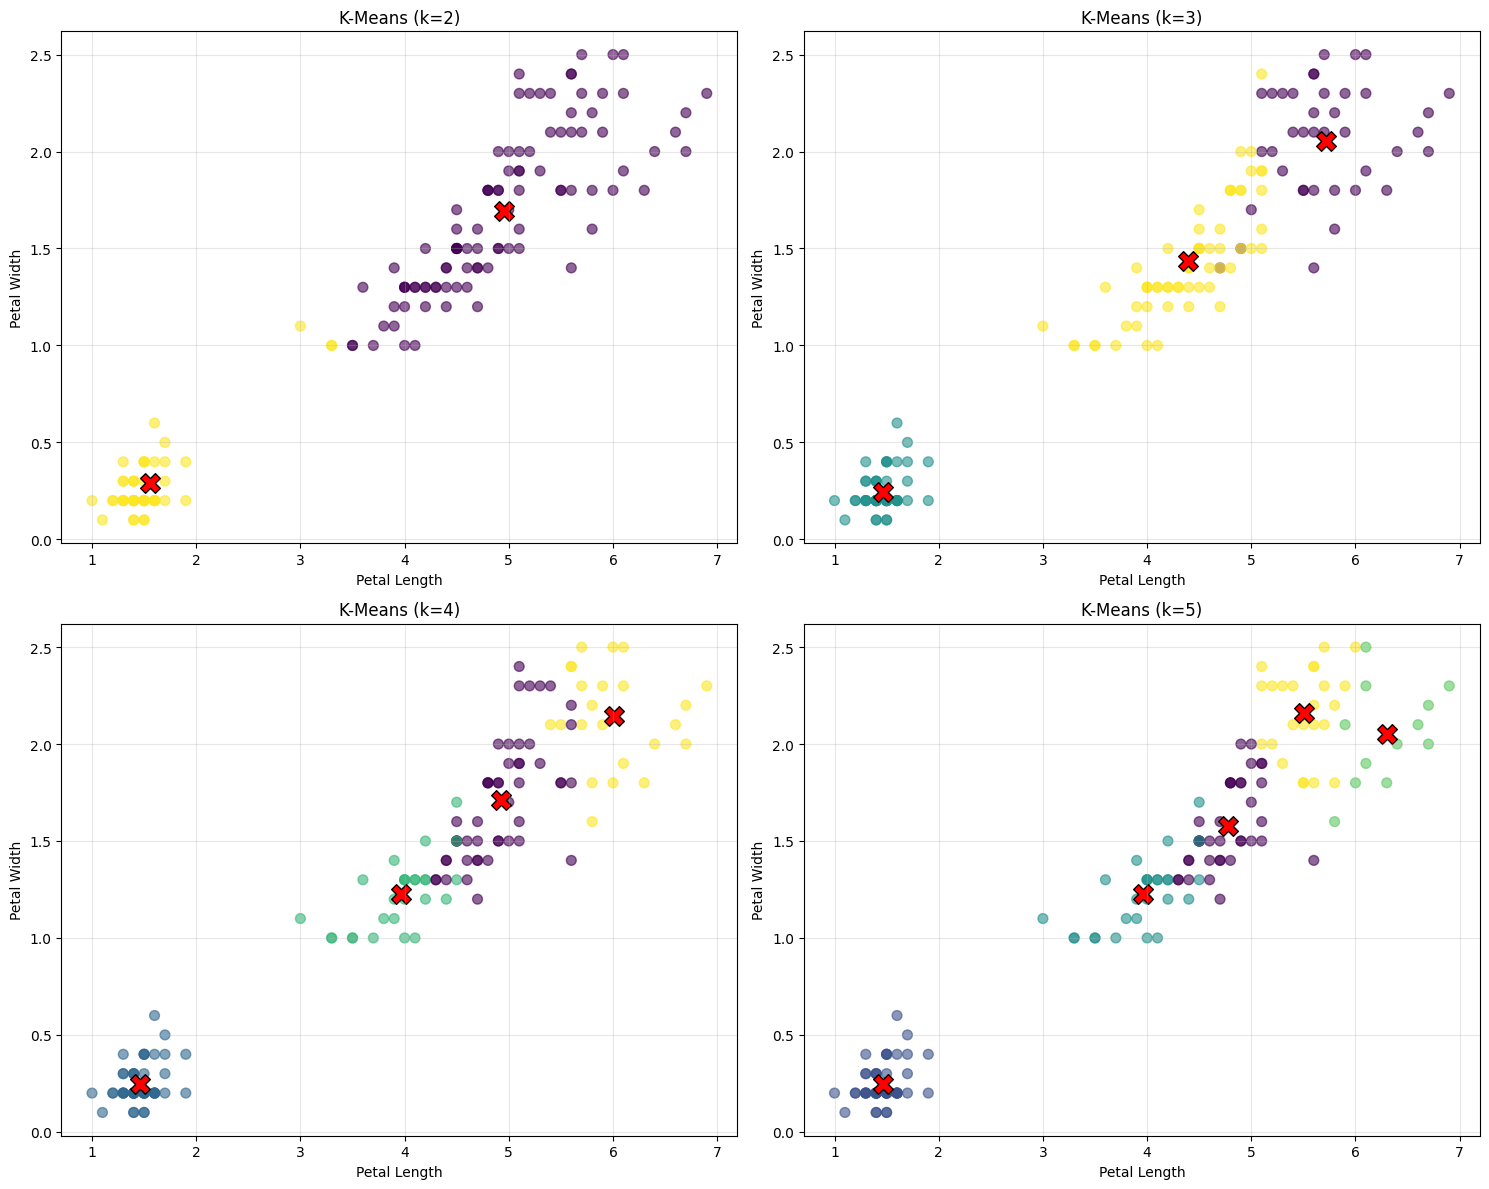

In [19]:
# 다양한 k 값으로 클러스터링 수행
k_values = [2, 3, 4, 5]
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, k in enumerate(k_values):
    # K-Means 클러스터링
    kmeans_iris = KMeans(n_clusters=k, random_state=42)
    y_pred = kmeans_iris.fit_predict(X_iris)
    centers_iris = kmeans_iris.cluster_centers_
    
    # 시각화 (꽃잎 길이 vs 꽃잎 너비)
    axes[idx].scatter(X_iris[:, 2], X_iris[:, 3], 
                     c=y_pred, cmap='viridis', s=50, alpha=0.6)
    axes[idx].scatter(centers_iris[:, 2], centers_iris[:, 3], 
                     c='red', s=200, marker='X', edgecolors='black')
    
    axes[idx].set_title(f'K-Means (k={k})')
    axes[idx].set_xlabel('Petal Length')
    axes[idx].set_ylabel('Petal Width')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 실제 레이블과 클러스터링 결과 비교

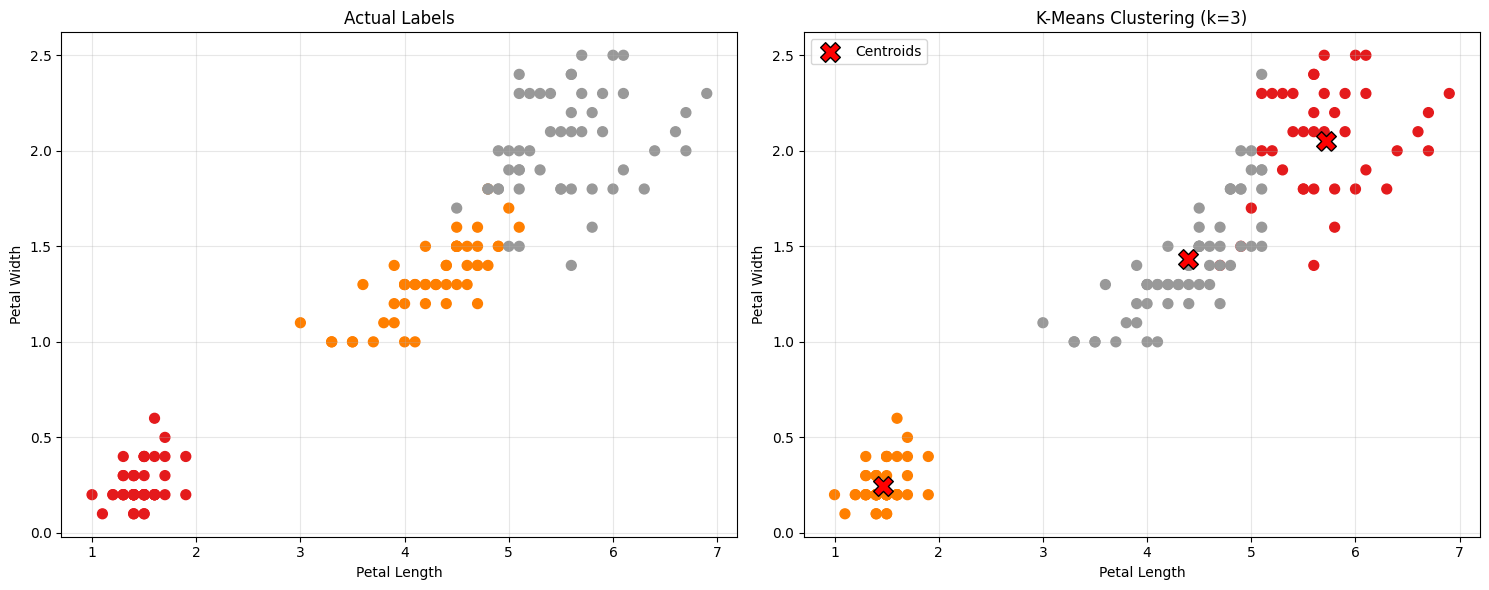

클러스터링 평가 결과
Adjusted Rand Index: 0.716
Silhouette Score: 0.551


In [20]:
# k=3으로 클러스터링 (실제 클래스 수와 동일)
kmeans_final = KMeans(n_clusters=3, random_state=42)
y_cluster = kmeans_final.fit_predict(X_iris)

# 실제 레이블과 클러스터링 결과 비교 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 실제 레이블
scatter1 = ax1.scatter(X_iris[:, 2], X_iris[:, 3], c=y_true, cmap='Set1', s=50)
ax1.set_title('Actual Labels')
ax1.set_xlabel('Petal Length')
ax1.set_ylabel('Petal Width')
ax1.grid(True, alpha=0.3)

# 클러스터링 결과
scatter2 = ax2.scatter(X_iris[:, 2], X_iris[:, 3], c=y_cluster, cmap='Set1', s=50)
ax2.scatter(kmeans_final.cluster_centers_[:, 2], kmeans_final.cluster_centers_[:, 3], 
           c='red', s=200, marker='X', edgecolors='black', label='Centroids')
ax2.set_title('K-Means Clustering (k=3)')
ax2.set_xlabel('Petal Length')
ax2.set_ylabel('Petal Width')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 클러스터링 성능 평가
ari = adjusted_rand_score(y_true, y_cluster)
silhouette = silhouette_score(X_iris, y_cluster)

print("="*50)
print("클러스터링 평가 결과")
print("="*50)
print(f"Adjusted Rand Index: {ari:.3f}")
print(f"Silhouette Score: {silhouette:.3f}")
print("="*50)

## 결론 및 요약

### 주성분분석(PCA)
- **목적**: 고차원 데이터의 차원 축소
- **장점**: 
  - 계산 속도 향상
  - 시각화 가능
  - 과적합 방지
  - 노이즈 제거
- **단점**: 
  - 해석이 어려움
  - 정보 손실 가능성

### 군집분석(K-Means)
- **목적**: 비지도 학습을 통한 데이터 그룹화
- **장점**: 
  - 간단하고 빠름
  - 구형 군집에 효과적
- **단점**: 
  - k 값을 미리 지정해야 함
  - 초기값에 민감
  - 비구형 군집에 부적합

### 실무 적용 팁
1. **PCA**: 특성 수가 많고 상관관계가 높을 때 사용
2. **K-Means**: 고객 세분화, 이미지 압축 등에 활용
3. **전처리**: 스케일링이 중요함
4. **평가**: 다양한 지표로 성능 검증 필요
